# Neural Style Transfer 

This notebook is an implementation of famous [neural style transfer](https://arxiv.org/pdf/1508.06576v2.pdf) algorithm combining keras's pretrained VGG19 and tensorflow.  

This project could be broken down into essentially 4 steps. 
- Importing VGG model from keras 
- Extract features and build the graph  
- Compute content and style loss
- Run the optimizer to minimize the total loss 
- Display the final output

Lets start by importing all the required libraries.

In [1]:
# import all the required libraries 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from scipy.misc import imread,imsave
from PIL import Image
import tensorflow as tf
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input, decode_predictions
from keras.models import Model
from keras.layers import Input
import keras.backend as K
import tempfile

import h5py

import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)
Using TensorFlow backend.


### Define feature layers and parameters
 
The idea is to extract features for both content and style images. We define content layer and the style layers for VGG 19 model. The style layer is defined as a dictionary with key as VGG19 layer and key as its weight. 

Further we define three parameters which gives different weights to each of the style and content loss. We start with a content image with added random noise. Noise ratio governs how much noise is added relative to the content image.

In [2]:
## Define the image paths
content_image_path = 'input_images/wolf.jpg'
style_image_path = 'input_images/chip.jpg'

# Define the content and style layers to be used for feature extraction
content_layer = 'block4_conv2'

Style_layer = {
    'block1_conv1': 0.2,
    'block2_conv1': 0.2,
    'block3_conv1': 0.2,
    'block4_conv1': 0.2,
    'block5_conv1': 0.2
}
# define the loss constants
alpha = 1e-1   # content loss weight 
beta = 1       # style loss weight
noise_ratio = 0.6 # Noise to content image ratio

### Defining VGG model class 

We will define a class called vgg to import VGG19 model from keras and save the model for reusing later with tensorflow. The reason we do this is because whenever we start a new tensorflow session without saving keras model first and initialize variables, the keras model will also get randomly initialized. To avoid this we save the model and later in the tensorflow session we reload the pretrained VGG19 weights

In [3]:

## Defining vgg class 
class vgg():
    def __init__(self,input_tensor=None):
        self._build_graph(input_tensor)


    def _build_graph(self,input_tensor):
        with tf.Session() as sess:
            self.input_tensor = input_tensor
            self.model = VGG19(weights='imagenet',include_top=False, input_tensor= self.input_tensor)
            self.outputs = {layer.name : layer.output for layer in self.model.layers}
            self.vgg_weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
        
            ## Save the temporary file    
            with tempfile.NamedTemporaryFile() as f:
                self.tf_checkpoint_path = tf.train.Saver(self.vgg_weights).save(sess, f.name)

        self.model_weights_tensors = set(self.vgg_weights)
    
    def load_weights(self):
        sess = tf.get_default_session()
        tf.train.Saver(self.vgg_weights).restore(sess,self.tf_checkpoint_path)
    
    def __getitem__(self, key):
        return self.outputs[key]    



### Define the losses 

There are 2 losses considered in the paper, content and style loss. Content loss is just the normalized squared difference between features of content and generated image. Style loss is weighted sum of normalied squared difference between gram matrix of features of style and generated images.

We also define some Helper functions to preprocess the image for VGG19 model and deprocess the final output for visualiation.  

In [4]:
## Define all the losses 

# Content Loss
def content_loss(content,generated):
    H,W,C = generated.get_shape().as_list()
    return tf.reduce_sum(tf.squared_difference(content,generated))/(4*H*W*C)

# Style Loss
def style_loss(style_features,gen_image_features,Style_layer):
    cost = 0 
    for key,val in Style_layer.iteritems():
        
        a_S = style_features[key]
        
        a_G = gen_image_features[key]
        
        cost += val*style_layer_loss(a_S,a_G)
    
    return cost

def style_layer_loss(style,generated):
    
    H,W,C = style.get_shape().as_list()
    S = tf.reshape(style,[H*W,C])
    G = tf.reshape(generated,[H*W,C])
    
    GS = tf.matmul(tf.transpose(S),S)  ## gram matrix
    GG = tf.matmul(tf.transpose(G),G)  ## gram matrix
    
    return tf.reduce_sum(tf.squared_difference(GG,GS))/(4*np.square(H*W*C))


## Total Loss 
def total_loss(content_loss,style_loss,alpha=1e-3,beta=1):
    return content_loss*alpha + beta*style_loss


## Helper image processing functions 

def preprocess_image(path):
    img = image.load_img(path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = preprocess_input(np.expand_dims(img, axis=0))
    #imshow(img[0])
    return img

def deprocess_image(x, img_nrows, img_ncols):
    if K.image_dim_ordering() == 'th':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
# Remove zero-center by mean pixel
        x[:, :, 0] += 103.939
        x[:, :, 1] += 116.779
        x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
        x = x[:, :, ::-1]
        x = np.clip(x, 0, 255).astype('uint8')
        #scipy.misc.imsave(path, x)
    return x

###  Extracting features from VGG19

We extract the relevant features by concantenating all the 3 images and feeding this combined tensor as input to VGG19 model.

In [5]:

## Load content Image  
base_img = preprocess_image(content_image_path)
content = tf.constant(base_img,tf.float32)

## Load Style Image
style_img = preprocess_image(style_image_path)
style = tf.constant(style_img,tf.float32)


## Noise Image 
noise_image = np.random.uniform(-20, 20, (1, 224, 224, 3)).astype('float32')
noise_image = noise_image * noise_ratio + base_img * (1-noise_ratio)
#imshow(noise_image[0])

gen_image = tf.Variable(noise_image)

## Run the vgg model on content,style and generated images 

input_tensor = tf.concat([content,style,gen_image],axis=0)

M1 = vgg(input_tensor=input_tensor)

## Derive relevant features 

# Content features
content_features = M1[content_layer][0]

# Style features
style_features = {x:M1[x][1] for x in Style_layer}

# Generated image features 
gen_image_features = {x:M1[x][2] for x in Style_layer}
gen_image_features[content_layer] = M1[content_layer][2]





### Build the Final Graph 

Now that we have all the required feautures, we add nodes to compute all the losses and the  Adam optimizer.

In [6]:
## Build the final graph 

content_cost = content_loss(content_features,gen_image_features[content_layer])
style_cost = style_loss(style_features,gen_image_features,Style_layer)

total_cost =  total_loss(content_cost,style_cost,alpha,beta)


train = tf.train.AdamOptimizer(learning_rate=5).minimize(total_cost,var_list = [gen_image])


### Running the optimization 

This is the final step. We initialize all the global variables and then load the pretrained VGG19 weights. The generated image is stored in the /output/ directory every 2 iterations.

In [7]:
## Training the network and optimization
with tf.Session() as sess:
    iterations = 500
    sess.run(tf.global_variables_initializer())
    M1.load_weights()
    for i in range(iterations):
        
        _,loss,output,J_style,J_content = sess.run([train,total_cost,gen_image,style_cost,content_cost])
        fname = 'output/output_after_iteration '+ str(i)+ '.png'
        out_img = deprocess_image(output,224,224)
        if i%2==0:imsave(fname,out_img)
        if i%50 == 0: print("iteration = %d , total_loss = %f" %(i,loss))    

INFO:tensorflow:Restoring parameters from /tmp/tmpWXBDsl
iteration = 0 , total_loss = 78044905472.000000
iteration = 50 , total_loss = 935755904.000000
iteration = 100 , total_loss = 398328192.000000
iteration = 150 , total_loss = 267021696.000000
iteration = 200 , total_loss = 204079680.000000
iteration = 250 , total_loss = 165835472.000000
iteration = 300 , total_loss = 140126848.000000
iteration = 350 , total_loss = 121143576.000000
iteration = 400 , total_loss = 106937240.000000
iteration = 450 , total_loss = 95763312.000000


### Final Output 
The following is the result of the optimization

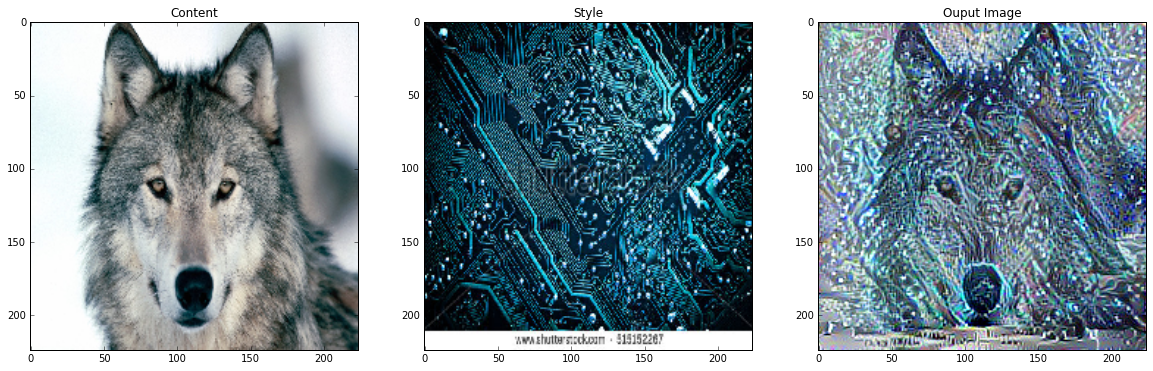

In [8]:
fig,axs = plt.subplots(1,3,figsize = (20,10))
axs[0].imshow(deprocess_image(base_img,224,224))
axs[0].set_title('Content')
axs[1].imshow(deprocess_image(style_img,224,224))
axs[1].set_title('Style')
axs[2].imshow(out_img)
axs[2].set_title('Ouput Image')
